<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/highdimensions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-NN in high dimensions: when it works, when it fails, and why

(Fayyaz Minhas)

This notebook demonstrates a classic **curse-of-dimensionality** failure mode for $k$-nearest neighbours ($k$-NN) with Euclidean distance, as analysed in several foundational machine learning and database theory papers.

We construct a controlled synthetic example where only a **fixed low-dimensional subspace** contains class information, while the remaining dimensions are **pure noise**. As we increase the total dimension $d$, we observe:

1. $k$-NN test accuracy **degrades**, despite unchanged underlying signal.
2. Pairwise Euclidean distances **concentrate**, making “nearest” neighbours less informative.

This behaviour is well known in theory but often surprising in practice.

---

## 1. The data-generating model

Each example has $d$ features, but only the first $d_{\text{sig}}$ are informative:
$$
x = (x_{\text{sig}}, x_{\text{noise}}) \in \mathbb{R}^{d_{\text{sig}}} \times \mathbb{R}^{d-d_{\text{sig}}}.
$$

Labels are $y \in \{0,1\}$, sampled with equal probability.

### Signal part (class-dependent)

The signal features follow Gaussian distributions with class-dependent means:
$$
x_{\text{sig}} \mid y=c \sim \mathcal{N}(\mu_c, I_{d_{\text{sig}}}),
$$
with
$$
\mu_0 = \left(-\frac{\Delta}{2}, 0, \dots, 0\right), \quad
\mu_1 = \left(+\frac{\Delta}{2}, 0, \dots, 0\right).
$$

Here $\Delta>0$ controls class separation.

### Noise part (class-independent)

The remaining dimensions are independent Gaussian noise:
$$
x_{\text{noise}} \sim \mathcal{N}(0, \sigma^2 I_{d-d_{\text{sig}}}),
$$
independent of the label.

**Key design choice:** $d_{\text{sig}}$ is fixed, and we increase $d$ by adding irrelevant noise dimensions.

---

## 2. What $k$-NN is doing

Given training data $\{(x_i,y_i)\}_{i=1}^n$, $k$-NN predicts the label of a test point $x$ by:

1. Computing Euclidean distances $\|x-x_i\|_2$.
2. Selecting the $k$ smallest distances:
$$
\mathcal{N}_k(x) = \arg\min_{|S|=k} \{\|x-x_i\|_2 : i\in S\}.
$$
3. Predicting by majority vote:
$$
\hat{y}(x) = \mathbb{1}\!\left[\sum_{i\in\mathcal{N}_k(x)} \mathbb{1}(y_i=1) > \frac{k}{2}\right].
$$

Thus, the method relies entirely on **distance ranking** being meaningful.

---

## 3. Why adding irrelevant dimensions breaks $k$-NN

The squared Euclidean distance decomposes as
$$
\|x-x'\|_2^2
=
\|x_{\text{sig}}-x'_{\text{sig}}\|_2^2
+
\|x_{\text{noise}}-x'_{\text{noise}}\|_2^2.
$$

The signal term scales with $d_{\text{sig}}$, which is fixed.  
The noise term scales with $m = d-d_{\text{sig}}$.

If
$$
x_{\text{noise}},x'_{\text{noise}} \sim \mathcal{N}(0,\sigma^2 I_m),
$$
then
$$
x_{\text{noise}}-x'_{\text{noise}} \sim \mathcal{N}(0,2\sigma^2 I_m),
$$
and
$$
\|x_{\text{noise}}-x'_{\text{noise}}\|_2^2 \sim 2\sigma^2 \chi^2_m.
$$

Hence:
$$
\mathbb{E}\big[\|x_{\text{noise}}-x'_{\text{noise}}\|_2^2\big] = 2\sigma^2 m,
$$
$$
\mathrm{Var}\big(\|x_{\text{noise}}-x'_{\text{noise}}\|_2^2\big) = 8\sigma^4 m.
$$

The **relative dispersion** decreases as:
$$
\frac{\sqrt{\mathrm{Var}}}{\mathbb{E}} = \sqrt{\frac{2}{m}} \;\longrightarrow\; 0
\quad\text{as } m\to\infty.
$$

This is the mathematical origin of **distance concentration**.

### Consequence for $k$-NN

When $m$ is large:
$$
\|x-x'\|_2^2 \approx 2\sigma^2(d-d_{\text{sig}}),
$$
almost regardless of class. Nearest neighbours are selected mainly due to noise fluctuations, not class structure, causing $k$-NN predictions to approach random guessing.

This phenomenon is analysed rigorously in:
- Beyer et al. (1999)
- Aggarwal et al. (2001)

---

## 4. Distance concentration metric used here

We quantify distance concentration via the **coefficient of variation (CV)**:
$$
\mathrm{CV}(D) = \frac{\mathrm{std}(D)}{\mathbb{E}[D]},
$$
where $D = \|x-x'\|_2$ over randomly sampled pairs.

A shrinking $\mathrm{CV}(D)$ indicates that distances are becoming increasingly similar, reducing neighbour contrast.

---

## 5. When and why $k$-NN fails (in this experiment)

$k$-NN degrades when:
- Many features are irrelevant ($d-d_{\text{sig}}$ large),
- Noise variance $\sigma^2$ is not negligible,
- Euclidean distance is used without feature weighting or metric learning,
- Sample size $n$ is modest relative to effective dimension.

This matches classical analyses of the **curse of dimensionality**.

---

## 6. When $k$-NN does *not* fail

$k$-NN can work well when:

- **Signal scales with dimension:** informative structure exists across many coordinates.
- **Irrelevant features are removed:** via feature selection or dimensionality reduction.
- **Metrics are learned:** distances reflect task-relevant similarity.
- **Signal-to-noise ratio is high:**
$$
\Delta^2 \gg \sigma^2(d-d_{\text{sig}}).
$$
- **Data is extremely abundant:** asymptotic guarantees apply.

---

## 7. What to look for in the plots

1. Accuracy vs $d$: degradation with irrelevant dimensions.
2. $\mathrm{CV}(D)$ vs $d$: shrinking relative distance spread.
3. Accuracy vs $\mathrm{CV}(D)$: loss of neighbour meaning as distances concentrate.

## Exercise

Try with different values of K. Do you notice any improvement?
Add more "signal" dimensions and observe the effect.

---

## References and further reading

- Bellman, R. (1961). *Adaptive Control Processes*. Princeton University Press.  
  (Origin of the term “curse of dimensionality”.)

- Cover, T. M., & Hart, P. E. (1967). Nearest Neighbor Pattern Classification.  
  *IEEE Transactions on Information Theory*, 13(1), 21–27.

- Beyer, K., Goldstein, J., Ramakrishnan, R., & Shaft, U. (1999).  
  *When Is Nearest Neighbor Meaningful?* Proceedings of SIGMOD.

- Aggarwal, C. C., Hinneburg, A., & Keim, D. A. (2001).  
  *On the Surprising Behavior of Distance Metrics in High Dimensional Space*.  
  Proceedings of ICDT.

- Hastie, T., Tibshirani, R., & Friedman, J. (2009).  
  *The Elements of Statistical Learning*, 2nd ed. Springer.  
  (Chapters on $k$-NN and the curse of dimensionality.)

These works provide the theoretical foundation for the behaviour illustrated in this notebook.


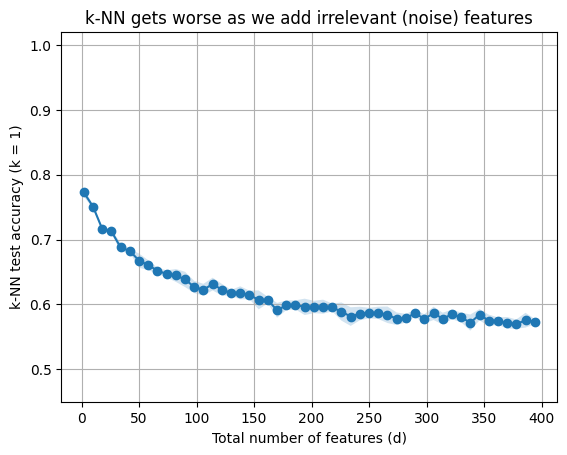

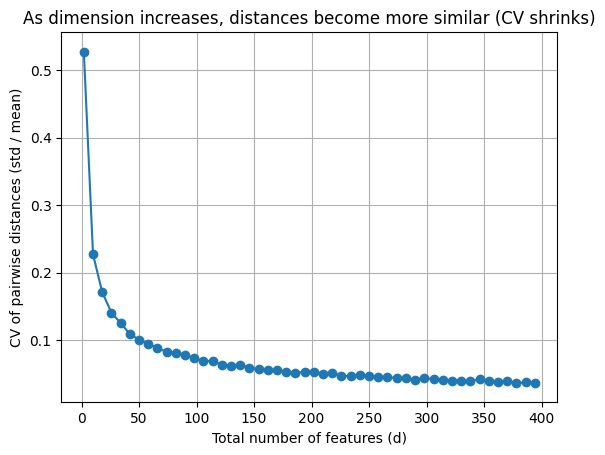

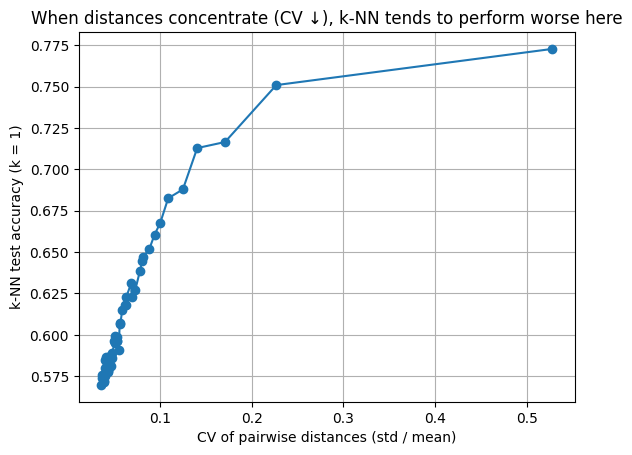

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) Make a simple dataset:
#    - Only the first d_signal features contain class information
#    - The remaining features are pure noise
# ============================================================

def make_data(n_train, n_test, d, d_signal=2, sep=2.0, noise_std=1.0, rng=None):
    """
    Binary classification dataset.

    Class label y in {0,1}.
    Signal: first d_signal dimensions. We shift class means along signal dim 0.
    Noise : remaining d - d_signal dimensions are label-independent Gaussian noise.
    """
    rng = np.random.default_rng() if rng is None else rng

    y_train = rng.integers(0, 2, size=n_train)
    y_test  = rng.integers(0, 2, size=n_test)

    # Class-dependent mean shift in the signal subspace
    mu0 = np.zeros(d_signal); mu0[0] = -sep / 2
    mu1 = np.zeros(d_signal); mu1[0] = +sep / 2

    # Signal features: Gaussian around mu0 or mu1 depending on class
    Xs_tr = rng.normal(size=(n_train, d_signal)) + np.where(y_train[:, None] == 1, mu1, mu0)
    Xs_te = rng.normal(size=(n_test,  d_signal)) + np.where(y_test[:, None]  == 1, mu1, mu0)

    # Noise features: Gaussian noise, same for both classes
    d_noise = max(d - d_signal, 0)
    Xn_tr = rng.normal(scale=noise_std, size=(n_train, d_noise)) if d_noise > 0 else np.empty((n_train, 0))
    Xn_te = rng.normal(scale=noise_std, size=(n_test,  d_noise)) if d_noise > 0 else np.empty((n_test,  0))

    X_train = np.concatenate([Xs_tr, Xn_tr], axis=1).astype(np.float32)
    X_test  = np.concatenate([Xs_te, Xn_te], axis=1).astype(np.float32)

    return X_train, y_train.astype(np.int8), X_test, y_test.astype(np.int8)


# ============================================================
# 2) k-NN prediction (chunked, to save memory)
# ============================================================

def knn_predict_chunked(X_train, y_train, X_test, k=5, chunk_size=256):
    """
    Predict labels for X_test using k-NN with Euclidean distance.

    We compute squared distances in chunks:
      d^2(a,b) = ||a||^2 + ||b||^2 - 2 a·b

    Then for each test point, find the k smallest distances and do majority vote.

    Tie-break rule:
      If votes are tied, we choose the smaller class label (0 over 1).
      (You can change this if you want a random tie-break.)
    """
    if k < 1:
        raise ValueError("k must be >= 1")
    if k > X_train.shape[0]:
        raise ValueError("k cannot be larger than number of training points")

    # Precompute ||x||^2 for each training vector (saves work)
    train_norm2 = np.sum(X_train * X_train, axis=1)  # shape (n_train,)

    y_pred = np.empty(X_test.shape[0], dtype=y_train.dtype)

    for start in range(0, X_test.shape[0], chunk_size):
        end = min(start + chunk_size, X_test.shape[0])
        T = X_test[start:end]  # (b, d)

        # ||t||^2 for each test vector in the chunk
        test_norm2 = np.sum(T * T, axis=1)[:, None]  # (b, 1)

        # Squared distances from each test point to all training points: (b, n_train)
        d2 = test_norm2 + train_norm2[None, :] - 2.0 * (T @ X_train.T)

        # Get indices of k nearest training points for each test point
        # argpartition is faster than argsort for just the smallest k
        knn_idx = np.argpartition(d2, kth=k-1, axis=1)[:, :k]  # (b, k)
        knn_labels = y_train[knn_idx]  # (b, k)

        # Majority vote for binary labels:
        # Count how many of the k neighbors are class 1.
        votes_for_1 = np.sum(knn_labels == 1, axis=1)  # (b,)
        # Predict 1 if strictly more than half the votes are 1, else 0.
        y_pred[start:end] = (votes_for_1 > (k / 2)).astype(y_train.dtype)

    return y_pred


# ============================================================
# 3) Distance concentration measure (CV = std/mean of distances)
# ============================================================

def pairwise_distance_cv(X, n_pairs=20000, rng=None):
    """
    Estimate the coefficient of variation (CV) of pairwise distances.

    We sample random pairs (i,j) and compute distances ||X[i] - X[j]||.
    CV = std(D) / mean(D).

    As dimension grows (with i.i.d. noise), CV typically shrinks: distances concentrate.
    """
    rng = np.random.default_rng() if rng is None else rng
    n = X.shape[0]

    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n, size=n_pairs)

    diff = X[i] - X[j]
    D = np.sqrt(np.sum(diff * diff, axis=1))
    return float(D.std() / D.mean())


# ============================================================
# 4) Run the experiment over many dimensions
# ============================================================

def run_experiment(
    dims,
    k=5,
    n_train=4000,
    n_test=4000,
    d_signal=2,
    sep=2.0,
    noise_std=1.0,
    trials=5,
    cv_pairs=20000,
    nn_chunk_size=256,
    seed=42
):
    """
    For each dimension d in dims:
      - generate data (signal dims fixed, rest noise)
      - run k-NN and compute test accuracy
      - estimate distance CV
    Repeat for multiple trials and report mean/std.
    """
    master = np.random.default_rng(seed)

    acc_mean, acc_std = [], []
    cv_mean, cv_std = [], []

    for d in dims:
        accs, cvs = [], []
        for _ in range(trials):
            trial_rng = np.random.default_rng(master.integers(0, 1_000_000_000))

            Xtr, ytr, Xte, yte = make_data(
                n_train=n_train, n_test=n_test, d=d,
                d_signal=d_signal, sep=sep, noise_std=noise_std,
                rng=trial_rng
            )

            yhat = knn_predict_chunked(Xtr, ytr, Xte, k=k, chunk_size=nn_chunk_size)
            accs.append(float((yhat == yte).mean()))

            Xpool = np.vstack([Xtr, Xte])
            cvs.append(pairwise_distance_cv(Xpool, n_pairs=cv_pairs, rng=trial_rng))

        acc_mean.append(np.mean(accs))
        acc_std.append(np.std(accs))
        cv_mean.append(np.mean(cvs))
        cv_std.append(np.std(cvs))

    return (np.array(acc_mean), np.array(acc_std),
            np.array(cv_mean),  np.array(cv_std))


# ============================================================
# 5) Main: make plots students can read easily
# ============================================================

if __name__ == "__main__":
    dims = np.arange(2, 401, 8)   # total dimension increases
    k = 1                        # try 1, 3, 5, 11, ...

    mean_acc, std_acc, mean_cv, std_cv = run_experiment(
        dims=dims,
        k=k,
        n_train=4000,
        n_test=4000,
        d_signal=1,
        sep=2.0,
        noise_std=1.0,
        trials=5,
        cv_pairs=2000,
        nn_chunk_size=256,
        seed=42
    )

    # Plot A: k-NN accuracy vs dimension
    plt.figure()
    plt.plot(dims, mean_acc, 'o-')
    plt.fill_between(dims, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)
    plt.ylim(0.45, 1.02)
    plt.grid(True)
    plt.xlabel("Total number of features (d)")
    plt.ylabel(f"k-NN test accuracy (k = {k})")
    plt.title("k-NN gets worse as we add irrelevant (noise) features")

    # Plot B: Distance concentration (CV) vs dimension
    plt.figure()
    plt.plot(dims, mean_cv, 'o-')
    plt.fill_between(dims, mean_cv - std_cv, mean_cv + std_cv, alpha=0.2)
    plt.grid(True)
    plt.xlabel("Total number of features (d)")
    plt.ylabel("CV of pairwise distances (std / mean)")
    plt.title("As dimension increases, distances become more similar (CV shrinks)")

    # Plot C: Accuracy vs CV (no fitting, just the relationship)
    plt.figure()
    plt.plot(mean_cv, mean_acc, 'o-')
    plt.grid(True)
    plt.xlabel("CV of pairwise distances (std / mean)")
    plt.ylabel(f"k-NN test accuracy (k = {k})")
    plt.title("When distances concentrate (CV ↓), k-NN tends to perform worse here")

    plt.show()


In [ ]:
~